# Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting
- Arxiv Paper: [Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting](https://arxiv.org/pdf/1912.09363.pdf)
- UCI ML Repository Data: [PEMS-SF Dataset](https://archive.ics.uci.edu/ml/datasets/PEMS-SF)

**FAQs**  
**What is multi-horizon forecasting(MHF)?**  
Multi-horizon forecasting(MHF) often contains a `complex mix of inputs` - including `static covariates`, known `future inputs` and other `exogenous time series` that are only observed in the past - without any prior information on how they interact witht the target.

**What is new in this paper?**  
There are many DL architectures published for multi-horizon forecasting problems but most of them are `black box` models. This paper brings insights into how the full range of inputs present in practical scenarios

**What is a `Temporal Fusion Transformer(TFT)`?**  
A TFT is a novel attention based architecture which combines high performance multi-horizon forecasting with interpretable insights into temporal dynamics.

**What is powers the TFT architecture?**    
To learn temporal relationship at different scales, TFT uses `Recurrent Neural Network(RNN)` for local processing and interpretable self-attention layers for long-term dependencies.
It utilizes specialized components to select relevant features and a series of gating layers to suppress unnecessary components, enabling high performance in a wide range of scenarios.

**What are the key DL concepts used?**
- Recurrent Neural Networks (RNN)
- Long Short Term Memory Networks (LSTM)
- Attention Based Models
- Transformer Based Models

**What challenges this paper specifically addresses that is not considered before?**
- Consideration of Exogenous inputs are known into the future
- Not neglecting static covariates
- Designing networks with suitable inductive biases 
- Considering heterogeneity of forecasting inputs

**Does this paper comes with source code?**  
Yes, the authors implemented on 3 of real-world datasets and demonstrated the significance of this architecture
1. Electricity: The UCI Electricity Load Diagrams Dataset containing electricity consumption of 370 customers - Frequency, Hourly
2. Traffic: The UCI PEM-SF Traffic Dataset describes the occupancy rate of freeways in Bay Area - Frequency, Hourly
3. Retail: Favorita Grocery Sales Dataset from Kaggle - Frequency, daily
4. Volatility: The OMI realized library contains daily realized volatility values of 31 stock indices - Frequency, daily(business days)

**Why transformers?**  
- RNN architecture fail to perform on long sequences efficiently
- They take more advantage of parallelism than RNN architectures like LSTM and GRUs
- Transformers ensures vanishing gradient problem isnt related with the length of the sequences.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Introduction
MHF, the prediction of variables of interest at multiple future time steps. It is a very important problem in time series ML. Most of the time series problems solves one time step ahead. For example, 
- Given a series of observations of event collected over a period of time, `what could be the next event`
- Given a list of closing day stock price for a given stock, `what is the price at the end of next day?`
- From the observations of monthly purchasing power of a household, `what could be the purchase amount for the next month?`
- Given unit of electricity consumed at hourly basis, `what is the power consumption by 10AM?`

In case of MHF, the above highlighted questions transform to multiple time steps
- what could be the next event $\Longrightarrow$ `what could be the next 4 subsequent events`
- what is the price at the end of next day? $\Longrightarrow$ `what is the end of day price for tomorrow, day-after-tomorrow and the the day after`
- what could be the purchase amount for the next month? $\Longrightarrow$ `what could be the purchase amount for the next 6 months?`
- what is the power consumption in the next 1 hour? $\Longrightarrow$ `what is the power consumption by 10AM, 11AM, Noon and 1PM?`

#### Data Source of MHF
MHFs have access to variety of data sources,heterogeneity of the data sources with little information about their interactions makes MHF a challenging problem, 
- Information about the future (e.g. upcoming holidays)
- exogenous time series(e.g. historical customer footprint)
- static meta data (e.g. geo-location of the store)

#### Usual Challenges 

- Common challenges or problems with `auto-regressing models` is assume all exogenous inputs are known into future
- These variables are simply concatenated with time-dependent features at each step
- Most architectures are black box, where forecasts are controlled by complex nonlinear interactions between many parameters
- Trustworthiness of the model is questioned due to the opaque nature

Further, commonly used explainability methods(LIME and SHAP) for DNNs are not well suited for applying to temporal data.
- LIME and SHAP do not consider the time ordering of input features
- LIME, surrogate models are independently constructed for each data-point
- SHAP features are considered independently for neighboring time steps
Such post-hoc approaches might lead to poor explanation quality as dependencies between time steps are typically significant in time series.

- Attention based architectures has the inherent interpretability for sequential data (e.g. language or speech). 
- Usually language or speech datasets are univariabe but temporal datas are multivariate, applying an Attention based model on such datasets is a novelty but heterogeneity of data is still a challenge

### 1.1 Temporal Fusion Transformers(TFT)
The TFT proposed in this paper is an attention based DNN architecture for MHF to achieve high performance while enabling interpretability.
Novel ideas incorporated, considering full range of potential inputs and temporal relationships of the variables, like
1. Static covariate encoders which `encode context vectors` for use in other parts of the network
2. **Gating mechanisms** is incorporated througout for sample dependent variable selection to minimize the contributions of irrelevant inputs
3. A sequence to sequence layer to locally process known and observed inputs
4. a temporal self-attention decoder to learn any long term dependencies present in the dataset - This facilitates the interpretability by identifying,  
    a. Globally important variables for the prediction problem  
    b. Persistent temporal patterns  
    c. Significant events, like regimes  
    
While conventional method assumes target alone to be fed into prediction recursion loop and ignores numerous useful time-varying inputs for the 2nd time step onwards. TFT explicitly accounts for the diversity of inputs. This is done by naturally handling static covariates and time-varying inputs

#### Time Series Interpretability with Attention - General Approach
Attention Mechanisms(AM) are used in 
- Translation[17]
- Image Classification[22]
- Tabular Learning[23]  

AMs identify saliance of input for each instance using the magnitude of attention weights. With interpretability motivations, time series researches[7, 12, 24] are conducted  using LSTM[25] and Transformer based architectures. However, it is usually done without giving importance to static covariates 

TFT alleviates the static covariates problem with separate `encoder-decoder attention` at each time step on top of the `self-attention` to determine the contribution of temporal input data.

Post-hoc interpretability methods(SHAP, LIME) are applied on pre-trained black-box models and often based on distilling into a `surrogate interpretable model` or `decomposing into feature attributions`. They are not designed to take into account the time ordering of inputs, limiting their use for complex time series data.

**Feature Selection Methods**
- Inherently, interpretable modeling approaches build components for feature seection directly into the architecture
- For time series forecasting, they are based on explicitly quantifying time-dependent variable contributions
- Interpretable Multi-Variable LSTMs[27] partitions the hidden state such that each variable contributes uniquely to its own memory segment and weights memory segments to determine variable contributions
- By computing `single contribution coefficient` based on attention weights, temporal importance and variable selections schemes are identified

TFT is designed to analyze global temporal relationships with input data and allow users to interpret global behviors of the model on the whole dataset. Specifically in the identification of any persistent patterns(e.g. seasonality or lag effects) and `regimes` present.

#### Related Work
- Traditional Multi Horizon Forecasting Methods[18, 19]
- Iterated approaches using auto-regressive models[9, 6, 12]
    - They are one step ahead prediction models with `multi-state predictions` obtained by recursively feeding predictions into future inputs
    - LSTM Networks like Deep AR[9] uses stacked LSTM to generate parameters of a predefined `linear state-space model` with predictive distributions produced via `Kalman Filter`
    - Further convolutional layers for `local processing` and a `sparse attention mechanism` to increase the `receptive field` during forecasting
    - These methods assumes target alone to be fed recursively into future inputs
- Direct methods based on sequence-to-sequence models[10, 11]
    - Direct methods explicity generate forecasts for multiple predefined horizons at each time step relying seq2seq architecture
    - LSTM encoders to summarize past inputs and a variety of methods to generate future predictions.
    - MQRNN[10] uses LSTM or Convolutional encoders to generate context vectors to feed into an MLP for each horizon
    - A multi-model attention mechanism is used with LSTM encoders to context vectors for a bi-directionsal LSTM decoder
    - Yet interpretability remains challenging
    
**Others**  
- Post-hoc explanations methods, [LIME, SHAP, RL-LIM],[15, 16, 26]
- Inherently interpretable models[27, 24]
- Methods combining temporal importance and variable selection[24]

## 2 Multi-Horizon Forecasting

### 2.1 Inputs and Targets
In a given time series dataset at each time step $\mathcal{t} \in [0, T_i]$

- $I$ is the unique number of entities. $\{i_1, i_2, i_3, \cdots, i_I\}$
- Each entity $i$ is associated with a set of static covariates. i.e. $\mathbf{s}_i \in \mathbb{R}^{m_s}$
- Inputs $\mathcal{X}_{i, t} \in \mathbb{R}^{m_x}$
- Targets $\mathcal{y}_{i,t} \in \mathbb{R}$

Time dependent inputs are divided into 2 categories  
 
$${\mathcal{X}_{i,t} = [\mathcal{z}^T_{i,t}, \mathcal{x}^T_{i,t}]^T}$$  

**Observed Inputs**  
Measured at each step and are unknown beforehand  
$$\mathcal{z}^T_{i,t} \in \mathbb{R}^{m_z}$$  
**Known Inputs**  
Inputs that are pre-determined (e.g. day of week at time $t$)
$$\mathcal{x}^T_{i,t} \in \mathbb{R}^{m_x}$$

#### Quantile Forecasting
The provision for prediction intervals can be useful for optimizing decisions and risk managemnt by yielding an indication of likely best and worst case values of the target. i.e. Adoption of quantile regression to MHF by setting [10, 50, 90] percentiles at each time step. Quantile forecast takes the form

$$\large{\hat{\mathcal{y_i}}(q, t, \tau) = f(q, \tau, y_{i, t-k:t}, z_{i, t-k:t}, x_{i,t-k:t + \tau}, s_i)}  \tag{1}$$

where,
- $\mathcal{\hat{y}_{i, t+\tau}}(q, t, \tau)$ is the predicted $q^{th}$ sample quantile of $\tau$ step ahead forecast at time $t$
- $f_q(\cdots)$ is the prediction model
- $k$ is the finite look back window of all past observations 
- $t$ is the start time of the forecast where target and known inputs are available only till time $t$.. i.e
$$y_{i, t-k:t} = \{y_{i,t-k}, \cdots, y_{i,t}\}$$
- All known inputs across the entire range is 
$$x_{i,t-k:t+\tau} = \{x_{i, t-k}, \cdots, x_{i, t + \tau}\}$$

Output forecasts for $\tau_{max}$ time steps - i.e. $\tau \in \{1, \cdots, \tau_{max}\}$


## 3. Model Architecture
TFT Architecture inputs,
- Static metadata
- Time varying past inputs
- Time varying a priori known future inputs

1. Variable selection  is used for judicious selection of the most salient features based on the input.  
2. Gated Residual Network(GRN) blocks enable efficient information flow with skip connections and gating layers.  
3. Time dependent processing is based on LSTMs for local processing and multi-head attention for integrating information from any time step

Building blocks of a TFT,  
1. **Gating Mechanisms**:  
    - GMs to skip over any unused components of the architecture, 
    - Provide adaptive depth and network complexity to accomodate a wide range of datasets and scenarios.


2. **Variable Selection Networks**:  
    - VSNs to select relevant input variables at each time step


3. **Static Covariate Encoders**:  
    - SCEs to integrate static features into the network, through encoding of `context vectors to condition temporal dynamics`.


4. **Temporal Processing**:  
    - TPs to learn both long and short-term temporal relationships from the observed and known time-varying inpts
    - A seq2seq layer is employed for local processing, 
    - Long term dependencies are captured using a novel interpretable multi-head attention block


5. **Prediction Intervals**:
    - PIs via quantile forecasts to determine the range of likely target values at each prediction horizon


### 3.1 Gating Mechanism - Gated Residual Network
- The relationship between exogenous inputs and targets are often unknown, makes it difficult to anticipate the relevance of a variable
- It is also difficult to determine the extent of required non-linear processing, and a simpler model might work better (e.g. small or noisy data)
- To make the model flexible, non-linear processing is applied on need bases.

The paper proposes Gated Residual Network(GRN) as a building block of TFT. The GRN takes primary input $a$ and an optional context vector $c$ and yields:

$${GRN_{\omega}(a, c) = LayerNorm(a + GLU_{\omega}(\eta_1)}) \tag{2}$$
$$\eta_1 = \mathbf{W}_{1,\omega} \eta_2 + \mathcal{b}_{1,\omega} \tag{3}$$
$$\eta_2 = ELU(\mathbf{W}_{s,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} )  \tag{4}$$

where,
- ELU is the Exponential Linear Unit activation function[28]
- $\eta_1 \in \mathbb{R}^{d_{model}}$ - Intermediate Layer
- $\eta_2 \in \mathbb{R}^{d_{model}}$ - Intermediate Layer
- $LayerNorm$ is standard layer normalization[29]
- $\omega$ is an index to denote weight sharing

ELU activation results in linear behavior by rendering 2 properties
- identity function $\mathbf{W}_{s,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} \gg 0$
- constant generator $\mathbf{W}_{2,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} \ll 0$



#### 3.1.1 Gated Linear Units(GLU)  
GLUs provide the flexibility to suppress any parts of architecture that are not required for a given dataset. 

Let $\mathfrak{\gamma} \in \mathbb{R}^{d_{model}}$ be the input, then

$$GLU_w(\mathcal{\gamma}) = \sigma(\mathbf{W}_{4, \omega} \gamma + b_{4, \omega}) \odot (\mathbf{W}_{5,\omega} + b_{5, \omega}) \tag{5}$$

where,
- $\sigma(\cdot)$ is the sigmoid activation functions
- $\mathbf{W} \in \mathbf{R}^{d_{model} x d_{model}}$ is the weight
- $b_{(\cdot)} \in \mathbf{R}^{d_{model}}$ is the bias
- $\odot$ is element wise `Hadamard Product` 
- $d_{model}$ is the hidden state size

1. GLU allows TFT to control the extent to which the GRN contributes to the original input $a$. 
2. It potentially skips over the layer entirely, if necessary GLU ouputs could be all close to 0 in order to suppress the nonlinear contribution
3. For instances without context vector, GRN simply treats the context to zero. i.e. $\mathcal{C} = 0$
4. During training, dropout is applied before the gating layer and layer normalization - i.e to $\eta_1$ in Eq.3

#### 3.1.2 Building Blocks of GRN

**Building Blocks of GRN**.  
- Linear Layer, `create_linear_layer`
- Gated Linear Unit, `GLU`
- Layer Normalization, `add_and_norm`

In [2]:
def create_linear_layer(
    size,
    activation=None,
    use_time_distributed=False,
    use_bias=True
):
    """
    Returns a Keras Linear Layer
    Args:
        size: Output Size
        activation: Activation function to apply if required
        use_time_distributed: Whether to apply layer across time
        use_bias: Whether bias should be included in the layer
    """
    linear = tf.keras.layers.Dense(
        size, activation=activation, use_bias=use_bias
    )
    if(use_time_distributed):
        linear = tf.keras.layers.TimeDistributed(linear)
    return linear

[[ 2.0365534  4.789449   1.1481645  1.4696901 -4.8679514]
 [ 7.9295135  3.1069307 -3.3238058  4.5486984 -4.0196204]]


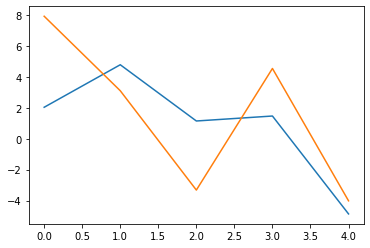

In [3]:
# A vanilla linear layer
rank_1_tensor = tf.constant([[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], [5.0, 4.0, 3.0, 2.0, 1.0, 0.0]])
linear_layer = create_linear_layer(5)
print(linear_layer)
output = linear_layer(rank_1_tensor)
print(output.numpy())
plt.plot(output.numpy()[0])
plt.plot(output.numpy()[1])

In [ ]:
# A sigmoid activation
# A ReLU activation
# A Softmax activation

**Apply Gating Layer, GLU**.  
- Dropout is applied before the gating layer and layer normalization, during training
- Equation (5), First Part - $\sigma(\mathbf{W}_{4, \omega} \gamma + b_{4, \omega})$
- Equation (5), Second Part - $(\mathbf{W}_{5,\omega} + b_{5, \omega})$
- ⊙ is element wise Hadamard Product: $GLU_w(\mathcal{\gamma}) = \sigma(\mathbf{W}_{4, \omega} \gamma + b_{4, \omega}) \odot (\mathbf{W}_{5,\omega} + b_{5, \omega})$
- Bias is not used here because in the subsequent steps, bias is added to the input during GRN creation

In [4]:
def GLU(
    x,
    hidden_layer_size,
    dropout_rate=None,
    use_time_distributed=True,
    activation=None
):
    """
    Applies a Gated Linear Unit to an input
    Args:
        x: Input to gating layer
        hidden_layer_size: Dimension of GLU
        dropout_rate: Dropout rate to apply
        use_time_distributed: Whether to apply across time
        activation: Activation function to apply to the linear feature transform if necessary
        
    Returns:
        Tuple of tensors for: (GLU output, gate)
    """
    
    x = tf.keras.layers.Dropout(dropout_rate)(x) if dropout_rate else x
    
    # Equation (5), First Part - 𝜎(𝐖4,𝜔𝛾+𝑏4,𝜔)
    dense_sigmoid = create_linear_layer(
        hidden_layer_size, 
        activation='sigmoid', 
        use_time_distributed=use_time_distributed,
        use_bias=False
    )                       
    gated_layer = dense_sigmoid(x)
    
    # Equation (5), Second Part - (𝐖5,𝜔+𝑏5,𝜔)(5)
    dense_activation = create_linear_layer(
        hidden_layer_size, 
        activation=activation, 
        use_time_distributed=use_time_distributed,
        use_bias=False
    )
    activation_layer = dense_activation(x)
    
    # ⊙ is element wise Hadamard Product: 𝐺𝐿𝑈𝑤(𝛾)=𝜎(𝐖4,𝜔𝛾+𝑏4,𝜔)⊙(𝐖5,𝜔+𝑏5,𝜔)
    hadammard_product = tf.keras.layers.Multiply()([activation_layer, gated_layer])
    
    return hadammard_product, gated_layer

**Add and Norm**  
Applies skip connection followed by layer normalization
- Skip connection and GLU applied eta_1 are added
- Result is normalized across the layer using LayerNorm - Mean close to 0 and STD close to 1

In [15]:
def add_and_norm(x_list, is_demo=False):
    """
    Applies skip connection followed by layer normalization
    Args:
        x_list: List of inputs to sum for skip connection
    Returns:
        Tensor output from layer
    """
    
    # Equation (2) Addition: 𝑎+𝐺𝐿𝑈𝜔(𝜂1)
    tmp = tf.keras.layers.Add()(x_list)
    if(is_demo):
        print(f'Equation (2) Addition: 𝑎+𝐺𝐿𝑈𝜔(𝜂1)\n{tmp.numpy()}')
    
    # Equation (2) Layer Normalization: 𝐺𝑅𝑁𝜔(𝑎,𝑐)=𝐿𝑎𝑦𝑒𝑟𝑁𝑜𝑟𝑚(𝑎+𝐺𝐿𝑈𝜔(𝜂1)
    tmp = tf.keras.layers.LayerNormalization()(tmp)
    if(is_demo):
        print(f'Equation (2) Layer Normalization: 𝐺𝑅𝑁𝜔(𝑎,𝑐)=𝐿𝑎𝑦𝑒𝑟𝑁𝑜𝑟𝑚(𝑎+𝐺𝐿𝑈𝜔(𝜂1)\n{tmp.numpy()}')
    return tmp

In [17]:
# Unit test add and norm
# GLU applied eta_1 and skip are passed to this method as an array
# Both are added and Layer Normed

x = tf.constant([[1.0, 2.0, 3.0]])
output = add_and_norm([x, x], is_demo=True)

Equation (2) Addition: 𝑎+𝐺𝐿𝑈𝜔(𝜂1)
[[2. 4. 6.]]
Equation (2) Layer Normalization: 𝐺𝑅𝑁𝜔(𝑎,𝑐)=𝐿𝑎𝑦𝑒𝑟𝑁𝑜𝑟𝑚(𝑎+𝐺𝐿𝑈𝜔(𝜂1)
[[-1.2245153  0.         1.2245153]]


#### 3.1.3 Build GRN
- Calculate 𝜂2: $ELU(\mathbf{W}_{s,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} )$
- Calculate 𝜂1 using 𝜂2: $\mathbf{W}_{1,\omega} \eta_2 + \mathcal{b}_{1,\omega}$
- Apply GLU - Gated Linear Unit on 𝜂1
- Apply Layer Normalization

**Calculate 𝜂1**  
𝜂1 is a simple linear layer applied on 𝜂2 obtained from the below method.

In [ ]:
def calculate_eta_1(eta_2, hidden_layer_size, use_time_distributed):
    return create_linear_layer(
        hidden_layer_size,
        activation=None,
        use_time_distributed=use_time_distributed
    )(eta_2)

**Calculate 𝜂2**  
- Create a linear layer with bias for the input: $\mathbf{W}_{s,\omega} a + \mathcal{b}_{2,\omega}$
- Create a linear layer for the additional context: $\mathbf{W}_{3,\omega} c$
- Add input layer and the context layer: $ELU(\mathbf{W}_{s,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} )$
- Apply `elu` activation for the input and context layer sum.

In [ ]:
def calculate_eta_2(x, additional_context, hidden_layer_size, use_time_distributed, is_demo=False):
    
    # Note bias is used here while creating the linear layer. ie use_bias=True
    # Equation (4) Part 1: 𝐖𝑠,𝜔𝑎 + b2,𝜔
    hidden = create_linear_layer(
        hidden_layer_size,
        activation=None,
        use_time_distributed=use_time_distributed
    )(x)
    
    if is_demo:
        print(f'Equation (4) Part 1: 𝐖𝑠,𝜔𝑎 + b2,𝜔\n{hidden}\n')
    
    # Equation (4) Part 2: 𝐖3,𝜔𝑐
    hidden_additional_context = None
    if(additional_context is not None):
        hidden_additional_context = create_linear_layer(
            hidden_layer_size,
            activation=None,
            use_time_distributed=use_time_distributed,
            use_bias=False
        )(additional_context)
    
    if is_demo:
        print(f'Equation (4) Part 2: 𝐖3,𝜔𝑐\n{hidden_additional_context}\n')
    
    # Equation (4) Add Part 1 and 2: 𝐖𝑠,𝜔𝑎+𝐖3,𝜔𝑐+b2,𝜔
    hidden = hidden + hidden_additional_context
    
    if is_demo:
        print(f'Equation (4) Add Part 1 and 2: 𝐖𝑠,𝜔𝑎+𝐖3,𝜔𝑐+b2,𝜔\n{hidden}\n')
    
    # Equation (4) Calculate 𝜂2=𝐸𝐿𝑈(𝐖𝑠,𝜔𝑎+𝐖3,𝜔𝑐+b2,𝜔)
    eta_2 = tf.keras.layers.Activation('elu')(hidden)
    
    return eta_2

Demonstration of `identity function` and `constant generator` using `ELU activation`
- identity function $\mathbf{W}_{s,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} \gg 0$
- constant generator $\mathbf{W}_{2,\omega} a + \mathbf{W}_{3,\omega} c + \mathcal{b}_{2,\omega} \ll 0$

\begin{equation*} 
\left\{ \normalsize
\begin{array}{lrc}
x & \mbox{for} & x \geq 0 \\
\alpha(e^x-1) & \mbox{for} & x < 0
\end{array}\right.
\end{equation*}

![Elu Activated Random Array](images/elu_activated_random_array.png)

In [ ]:
# Test eta_2 calculator

rank_1_tensor = tf.constant([[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]])
additional_context = tf.constant([[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]])
hidden_layer_size = 5
use_time_disributed = False

eta_2 = calculate_eta_2(rank_1_tensor, additional_context, hidden_layer_size, use_time_distributed=use_time_disributed, is_demo=True)
print(f'Equation (4) Calculate 𝜂2=𝐸𝐿𝑈(𝐖𝑠,𝜔𝑎+𝐖3,𝜔𝑐+b2,𝜔)\n{eta_2}\n')

**Calculate GRN**.  
Assemble all the above building blocks to apply a Gated Residual Network

In [ ]:
def GRN(
    x,
    hidden_layer_size,
    output_size=None,
    dropout_rate=None,
    use_time_distributed=True,
    additional_context=None,
    return_gate=False
):
    """
    Applies a Gated Residual Network as defined in the paper
    Args:
        x: Network inputs
        hidden_layer_size: Internal state size
        output_size: Size of the output layer
        dropout_rate: ...
        use_time_distributed: ...
        additional_context: Additional context vector to use if relevant
        return_gate: Whether to return GLU gate for diagnostic purposes
        
    Returns:
        Tuple of tensors for: (GRN output, GLU gate)
    """
    # Setup skip connection
    #  Equation (2): a in this equation is skip. 𝐺𝑅𝑁𝜔(𝑎,𝑐)=𝐿𝑎𝑦𝑒𝑟𝑁𝑜𝑟𝑚(𝑎+𝐺𝐿𝑈𝜔(𝜂1))
    if(output_size is None):
        output_size = hidden_layer_size
        skip = x
    else:
        linear = create_linear_layer(
            output_size, 
            use_time_distributed=use_time_distributed
        )
        skip = linear(x)
       
    # Equation (4): 𝜂2=𝐸𝐿𝑈(𝐖𝑠,𝜔𝑎+𝐖3,𝜔𝑐+b2,𝜔)
    eta_2 = calculate_eta_2(x, hidden_layer_size, use_time_distributed)
    
    # Equation (3): 𝜂1=𝐖1,𝜔𝜂2+b1,𝜔
    eta_1 = calculate_eta_1(eta_2, hidden_layer_size, use_time_distributed)
    
    # Equation (2): 𝐺𝐿𝑈𝜔(𝜂1)
    gating_layer, gate = GLU(
        eta_1, 
        output_size, 
        dropout_rate=dropout_rate, 
        use_time_distributed=use_time_distributed, 
        activation=None
    )
    
    # Equation (2): 𝐺𝑅𝑁𝜔(𝑎,𝑐)=𝐿𝑎𝑦𝑒𝑟𝑁𝑜𝑟𝑚(𝑎+𝐺𝐿𝑈𝜔(𝜂1))
    grn = add_and_norm([skip, gating_layer])
    
    return grn, gate if return_gate else grn

### 3.2 Variable Selection Networks
Relevance of a specific variable from the dataset and its contributions are unknown while training a deep neural network. TFT is designed to provide `instance-wise variable selection through`
- The use of `variable selection networks` applied to both static covariates and time dependent covariates to pick the most salient variables from dataset
- Variable selection also allows TFT to remove any unnecessary noisy inputs that may impact the performance negatively

This is accomplished using entity embeddings[31] for categorical variabls as feature representations and linear transformations for continuous variables.
- Entity embeddings transform a variable into $d_{model}$ dimensional vector that matches the dimensions in the subsequent layers for skip connections
- All static, past and future inputs make use of separate variable selection networks
- Variable selection network for past inputs are presented without losing generality

Let,
- $\xi^{(j)}_t \in \mathbb{R}^{d_model}$ denote the `transformed input` of the j-th variable at time t
- $\Xi_t  = [\xi ^{(1)^T}_t, \cdots, \xi^{(m_{\mathcal{x}})}_t]^T$ being the `flattened vector of all past inputs` at time $t$

Variable selection weights are generated by feeding $\Xi_t$ and an external context vector $\large\mathcal{c}_s$ through a GRN and then a Softmax Layer

$${\mathcal{V_{Xt}} = Softmax(GRN_{\mathcal{V_{Xt}}}(\Xi_t, \large\mathcal{c}_s))}\tag{6}$$

where,
- $\mathcal{V_{Xt}} \in \mathbb{R}^{m_x}$ is a vector of variable selections weights 
- $\mathcal{c}_s$ is obtained from a statice covariate encoder
- For static variables, the context vector $\large\mathcal{c}_s$ is omitted - given it already has access to static information

At each time step an additional layer of non-linear processing is employed by feeding $\xi^{(j)}_t$ through its own GRN

$${\tilde{\xi}^{(j)}_t =  GRN_{\tilde{\xi}(j)}(\xi^{}_t)}\tag{7}$$

Where,
- $\tilde{\xi}^{(j)}_t$ is the `processed feature vector` for variable $j$
- Note, each variable has its own GRN with weights shared across all time steps $t$
- Processed features are then weighted by their variable selection weights and combined

$${\tilde{\xi_t}} = \sum^{\mathcal{m_x}}_{j=1} \mathcal{V^{(j)}_{Xt}} \tilde{\xi_t}^{(j)}  \tag{8}$$

Where,
- $\mathcal{V^{(j)}_{Xt}}$ is the $j^{th}$ element of vector $\mathcal{V_{Xt}}$

### 3.3 Static Covariate Encoders
TFT uses separate GRN encoders to integrate information from static metadata to produce 4 different context vectors
$$\large[\mathcal{c}_s, \large\mathcal{c}_e, \large\mathcal{c}_c, \large\mathcal{c}_h]$$
These context vectors are wired into various locations in the Temporal Fusion Decoder(TFD).
- $\mathcal{c}_s$ is temporal variable selection
- $(\mathcal{c}_c, \mathcal{c}_h)$ Local processing of Temporal Features
- $\mathcal{c}_e$ Enriching of temporal features with static information

Let, $\zeta$ be the output of the static variable selection network, context for temporal varialble selection would be encoded according to 
$$\mathcal{c}_s = GRN_{\mathcal{c}_s}(\zeta)$$

### 3.4 Interpretable Multi-Head Attention
TFT employs a `self-attention mechanism` to learn long-term relationships across different time steps, which we modify from `multi-head attention` in transformer based architectures[17, 12] to enhance explainability.

**The Q, K and V**
- Attention mechanisms `scales values` ${V} \in \mathbb{R}^{Nxd_v}$ relationship between keys(K) and queries(Q)
- $K \in \mathbb{R}^{Nxd_{attn}}$ is the Key
- $Q \in \mathbb{R}^{Nxd_{attn}}$ is the Query

$$Attention({Q, K, V}) = A({Q,K})V\tag{9}$$

Where,
- $A()$ is the normalization function - A common choice is scaled dot-product attention

$$A({Q,K}) = Softmax(\frac{QK^T}{\sqrt{d_{attn}} })\tag{10}$$

Multi Head Attention is proposed in employing different heads for different representation subspaces to increase the learning capacity
$$MultiHead{(Q,K,V)}) = [H_1, \cdots, H_{m_H}]W_H\tag{11}$$
$$H_h = Attention(QW^{(h)}_Q, KW^{(h)}_K, VW^{(h)}_V) \tag{12}$$

Where,
- $W^{(h)}_K \in \mathbb{R}^{d_{model} x d_{attn}}$ is head specific weights for keys
- $W^{(h)}_Q \in \mathbb{R}^{d_{model} x d_{attn}}$ is head specific weights for queries
- $W^{(h)}_V \in \mathbb{R}^{d_{model} x d_{V}}$ is head specific weights for values

$W_H \in \mathbb{R}^{(m_h.d_V)xd_{model}}$ linearly combines outputs contatenated from all heads $H_h$

1. Since different values are used in each head, attention weights alone is not indicative of a feature's importance
2. Multi-head attention to share values in each head, and employ `additive aggregation` of all heads
$$InterpretableMultiHead(Q, K, V) = \tilde H \tilde{W}_H \tag{13}$$
$\tilde H = \tilde A(Q, K)V W_V \tag{14}$  

$\tilde H =  \huge\{ \normalsize 1/H  \sum^{m_H}_{h=1} A(QW^{(h)}_Q, KW^{(h)}_K)  \huge\}\normalsize VW_V \tag{15}$  
$\tilde H =  1/H  \sum^{m_H}_{h=1} A(QW^{(h)}_Q, KW^{(h)}_K, VW_V)\tag{16}$

Where,
- $W_v \in \mathbb{R}^{d_{model} x d_V}$ are value weights shared across all heads
- $W_H \in \mathbb{R}^{d_{attn} x d_{model}}$ is used for final linear mapping

1. Through this, each head can learn different temporal patterns, while attending to a common set of input features.
2. These features can be interpretted as a simple ensemble over attention weights into combined matrix $\tilde A(Q, K)$ Eq.14.
3. Compared to $A(Q, K)$ Eq.10 in $\tilde A(Q, K)$ Eq.14 yields an increased representation capacity in an efficient way

### 3.5 Temporal Fusion Decoder
The TFD uses a series of layers descriped below to learn temporal relationships present in the dataset
- Locality Enhancement with Sequence-to-Sequence Layer
- Static Enrichment Layer
- Temporal Self-Attention Layer
- Position-wise Feed-forward Layer
- Quantile Outputs

#### 3.5.1 Locality Enhancement with Seq2Seq Layer
In time series data, points of significance are often identified in relation to their surrounding values, such as
- Anomalies
- Change-points
- Cyclical patterns  

Through the construction of features that utilize pattern information on top of `point-wise values` potentially gives better performance in attention based architecture. For e.g.[12] adopts a single convolutional layer for locality enhancement by extracting local patterns using the same filter across all time. This approach may not be suitable when observed inputs exists, due to the differing number of past and future inputs.

This paper proposes, 
- The application of a sequence-to-sequence model to naturally handle these differences - feeding $\tilde\xi_{t-k:t}$ into the encoder and $\tilde\xi_{t+1:t+\tau_{max}}$ into the decoder
- This then generates a set of uniform temporal features which serve as inputs into the temporal fusion decoder itself - $\phi(t,n) \in {\phi(t, -k), \cdots, \phi(t, \tau_{max})}$, n is a position index
- Commonly used seq2seq baselines are compared with LSTM decoder-encoder
- LSTM serves as a replacement for standard positional encoding, providing an appropriate `inductive bias` for the time ordering of the inputs
- To Allow static metadata to influence local processing, $C_c, C_h$ context vectors from the static covariate encoders to initialize the `cell state and hidden state` respectively for the first LSTM in the layer.
- A gated skip connection is employed over this layer

$$\tilde\phi(t, n) = LayerNorm(\tilde\xi_{t+n} + GLU_{\tilde\phi}(\phi(t, n)))\tag{17}$$

Where, $\mathcal{n} \in [-k, \tau_{max}]$ is a position index

#### 3.5.2 Static Enrichment Layer
A static enrichment layer that enhances temporal features with static metadata. For a position index $n$, static enrichment takes the form
$$\theta(t,n) = GRN_{\theta}(\tilde\phi(t,n), \mathcal{c}_e) \tag{18}$$
Where,
- Weights of $GRN_{\phi}$ are shared across the entire layer
- $\mathcal{c}_e$ is a context vector from the static covariate

#### 3.5.3 Temporal Self-Attention Layer
- All static-enriched temporal features are first grouped into a single matrix  $ \Theta(t) = [\theta(t, -k), \cdots, \theta(t, \tau_{max})]^T$
- Then interpretable multi-head attention is applied at each forecast time - $N = \tau_{max} + k + 1$
$$B(t) = InterpretableMultiHead(\Theta(t), \Theta(t), \Theta(t))\tag{19}$$
- Yields $ \beta(t) = [\beta(t, -k), \cdots, \beta(t, \tau_{max})]$
- $d_V = d_{attn} = d_{model}/m_H$ are chosen where $m_h$ is the number of heads

1. `Decoder masking`[17, 12] is applied to the multi-head attention layer to ensure that each temporal dimension can only attend to features preceeding it.
2. Decoder Masking ensures `causal information flow` is preserved 
3. The self-attention layer allows TFT to pick up long-range dependencies that may be challenging for RNN based architectures to learn
4. Following the self-attention layer, a gating layer is also applied to facilitate training
$$\delta(t,n) = LayerNorm(\theta(t,n) + GLU_{\delta}(\beta(t,n))\tag{20}$$


#### 3.5.4 Position-wise Feed-forward Layer
An additional non-linear processing to the outputs of self attention layer is applied using GRNs
$$\psi(t,n) = GRN_{\psi}(\delta(t, n))\tag{21}$$

Where,
- Weights of $GRN_\psi$ are shared across the entire layer
- A `Gated Residual Connection` is applidd that skips over the entire transformer block
- This skip provides a direct path to sequence-to-sequence layer - yields, a simpler model when complexity is not required
$$\tilde\psi(t,n) = LayerNorm(\tilde\phi(t, n) + GLU_{\tilde\psi}(\psi(t,n))\tag{22}$$

### 3.6 Quantile Outputs
1. TFT generates prediction intervals on `top of point forecasts`[10] by achieving $[10^{th}, 50^{th}, 90^{th}]$ percentile predictions at each time step
2. Quantile forecasts are generated using linear transformation of the output from the temporal fusion decoder
$$\hat{y}(q, t, \tau) = \mathbf{W}_q\tilde\psi(t, \tau) + b_q \tag{23}$$

Where,
- $W_q \in \mathbb{R}^{1xd}, b_q \in \mathbb{R}$ are linear coefficients for the specified quantile $q$
- Forecasts are only generated for horizons in the future $\tau \in \{1, \cdots, \tau_{max}\}$

## 4. Loss Functions
TFT is trained by jointly minimizing the quantile loss, summed across all quantile outputs

$$\mathcal{L}(\Omega, W) = \sum_{y_t\in\Omega}\sum_{q\in\mathcal{Q}}\sum_{\tau=1}^{\tau_{max}}\frac{QL(y_t, \hat y(q, t - \tau, \tau), q)}{M\tau_{max}}\tag{24}$$
$$QL(y, \hat y, q) = q(y-\hat y)_+ + (1-q)(\hat y - y)_+ \tag{25}$$

Where, 
- $\Omega$ is the domain of training data containing M samples
- $W$ represents the weights of TFT
- $\mathcal{Q} = \{0.1, 0.5, 0.9\}$ is the set of output quantiles. ie $(.)_+ = max(0, .)$
- For `out of sample testing`, normalized quantile losses across the entire forecasting horizon is evaluated - focusing P50 and P90 risk for consistency with previous work[9, 6, 12]

$$q-Risk = \frac{2 \sum_{y_t\in\tilde\Omega}\sum_{\tau=1}^{\tau_{max}}QL(y_t, \hat y(q, t-\tau, \tau), q)}{\sum_{y_t\in\tilde\Omega}\sum_{\tau=1}^{\tau_{max}}|y_t|}\tag{26}$$

Where, $\tilde\Omega$ is the domain of test samples

### 4.1 Calculate Normalized Quantile Loss(q-Risk)

Let us calculated `q-Risk` in two steps for a single observation
1. Calculate Quantile Loss Weighted Errors
2. Calculate Normalized Quantile Loss(q-Risk)

**quantile_loss_weighted_errors**: $QL(y, \hat y, q)$, Eqn 25
$$QL(y, \hat y, q) = q(y-\hat y)_+ + (1-q)(\hat y - y)_+$$

In [ ]:
def quantile_loss_weighted_errors(y, y_hat, quantile):
    prediction_underflow = y - y_hat
    weighted_errors = quantile * np.maximum(prediction_underflow, 0.0) + (1 - quantile) * np.maximum(-prediction_underflow, 0.0)
    return weighted_errors

**q-risk, quantile loss**: Calculate quantile loss and q-Risk for single observation set  
from Eqn 24
    $$quantile\_loss = \frac{QL(y, \hat y, q)}{M}$$
from Eqn 26
    $$q\_Risk = \frac{2 \times QL(y_t, \hat y(q, t-\tau, \tau), q)}{|y_t|}$$

In [ ]:
def quantile_loss(y, y_hat, quantile):
    """
    Calculate the weighted error for the quantile loss q-risk calculation
    Args:
        y: target outcome
        y_hat: predicted outcome
        quantile: Quantile to use for loss calculations. range [0,1]
    Outputs:
        Float for normalized quantile loss
    """    
    weighted_errors = quantile_loss_weighted_errors(y, y_hat, quantile)
    quantile_loss = weighted_errors.mean()
    normalizer = np.abs(y).mean()
    return 2 * quantile_loss / normalizer

In [ ]:

y = np.array([1, -2, 3, -4, 5])
y_hat = np.array([1, -3, 2, -5, 4])

quantiles = np.array([0.1, 0.5, 0.9])
[quantile_loss(y, y_hat, q) for q in quantiles]